#### Calculo de Auto Correlation Bright/Faint - TreeCorr

In [20]:
def generate_RandomCatalogue(ra,dec,nmult,seed,mask=True):
    
    np.random.seed(seed)

    ra_min = np.min(ra)
    ra_max = np.max(ra)
    dec_min = np.min(dec)
    dec_max = np.max(dec)

    rand_ra = np.random.uniform(ra_min, ra_max, len(ra)*nmult)
    rand_sindec = np.random.uniform(np.sin(dec_min*np.pi/180.), np.sin(dec_max*np.pi/180.), \
                                    len(ra)*nmult)
    rand_dec = np.arcsin(rand_sindec)*180./np.pi

    #Eliminates points within 5° in galactic latitude
    if mask==True:
        ran = SkyCoord(rand_ra,rand_dec,frame='icrs',unit='degree')
        mask_ran = np.where([abs(ran.galactic.b)>5.*(u.degree)])[1]
        rand_ra = rand_ra[mask_ran]
        rand_dec = rand_dec[mask_ran]

    return rand_ra, rand_dec

######################
minsep = 10.
maxsep = 90.
nbins = 15
nmult = 50
npatch = 20

seed1 = 12936
seed2 = 19284

config = {"min_sep": minsep, "max_sep": maxsep, "nbins": nbins, "sep_units": 'degree', \
          "bin_type": 'Linear', "brute": True, "metric": 'Arc',"var_method": 'bootstrap', "num_bootstrap": 500}

passivecrop = True
write = True
plot = True
######################

from astropy.io import ascii
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

# Read Gxs
if passivecrop==True: filename_g = '../data/VLS/2MRSxWISE_VLS_passivecrop.txt'
else: filename_g = '../data/VLS/2MRSxWISE_VLS.txt'
data = ascii.read(filename_g)

# Bright/Faint
data_bright = data[(data['K_abs']<-23.2)&(data['K_abs']>-26.)]
data_faint = data[(data['K_abs']>-23.2)&(data['K_abs']<-22.)]

# Random Catalogue
rand_ra1, rand_dec1 = generate_RandomCatalogue(data_bright['_RAJ2000'],data_bright['_DEJ2000'],\
                                               nmult,seed1,mask=True)
rand_ra2, rand_dec2 = generate_RandomCatalogue(data_faint['_RAJ2000'],data_faint['_DEJ2000'],\
                                               nmult,seed2,mask=True)

"""
BRIGHT
"""
import treecorr

gcat = treecorr.Catalog(ra=data_bright['_RAJ2000'], dec=data_bright['_DEJ2000'],\
                        ra_units='deg', dec_units='deg',npatch=npatch)
rcat1 = treecorr.Catalog(ra=rand_ra1, dec=rand_dec1, ra_units='deg', dec_units='deg', npatch=npatch)

dd = treecorr.NNCorrelation(config)
dr = treecorr.NNCorrelation(config)
rr = treecorr.NNCorrelation(config)

rr.process(rcat1)
dd.process(gcat)
dr.process(gcat,rcat1)

xi_auto_bright, varxi_auto_bright = dd.calculateXi(rr=rr,dr=dr)

"""
FAINT
"""
gcat = treecorr.Catalog(ra=data_faint['_RAJ2000'], dec=data_faint['_DEJ2000'],\
                        ra_units='deg', dec_units='deg', npatch=npatch)
rcat2 = treecorr.Catalog(ra=rand_ra2, dec=rand_dec2, ra_units='deg', dec_units='deg', npatch=npatch)


dd = treecorr.NNCorrelation(config)
dr = treecorr.NNCorrelation(config)
rr = treecorr.NNCorrelation(config)

rr.process(rcat2)
dd.process(gcat)
dr.process(gcat,rcat2)

xi_auto_faint, varxi_auto_faint = dd.calculateXi(rr=rr,dr=dr)

#### Plot

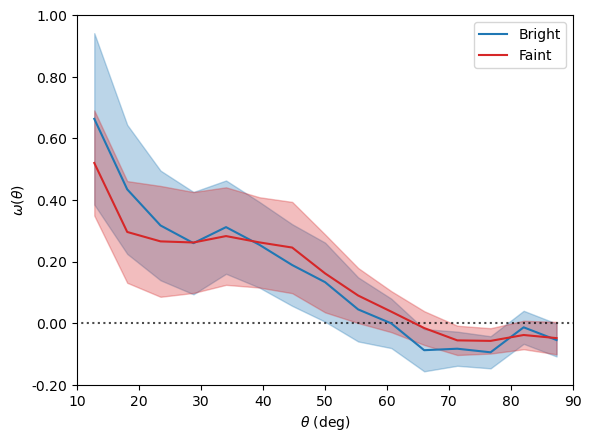

In [26]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()

sig_auto_bright = (varxi_auto_bright)
sig_auto_faint = (varxi_auto_faint)
#print(sig_auto_bright,sig_auto_faint)
r = np.exp(dd.meanlogr)
r = dd.meanr

ax.hlines(0.,0.,90.,ls=':',color='k',alpha=.7)

ax.plot(r, xi_auto_bright, color='C0', label='Bright')
ax.plot(r, xi_auto_faint, color='C3', label='Faint')

ax.fill_between(r, y1=xi_auto_bright-sig_auto_bright, y2=xi_auto_bright+sig_auto_bright, \
                color='C0', alpha=.3)
ax.fill_between(r, y1=xi_auto_faint-sig_auto_faint, y2=xi_auto_faint+sig_auto_faint, \
                color='C3', alpha=.3)


ax.legend()

ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylabel(r'$\omega(\theta)$')

ax.set_xlim([minsep,maxsep])
ax.set_ylim([-.2,1.])

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

if plot==True:
    plotname = f'../plots/auto_treecorr_bf_{nmult}' 
    if passivecrop==True: plotname+='_passivecrop'
    plt.savefig(plotname+'png')


plt.show()


#### Write

In [22]:
if write==True:
    fname_b = f'../data/treecorr_auto_bright_{nmult}'
    fname_f = f'../data/treecorr_auto_faint_{nmult}'
    if passivecrop==True:
        for name in [fname_b,fname_f]:
            name+='_passivecrop'
    np.savez(fname_b+'.npz',r,xi_auto_bright,sig_auto_bright)
    np.savez(fname_f+'.npz',r,xi_auto_faint,sig_auto_faint)